In [ ]:
!pip install music21

In [ ]:
!pip install mido

In [ ]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio

In [ ]:
import os
import random
import music21
import numpy as np
from music21 import converter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Data**

In [ ]:
midi_folder = "/content/drive/MyDrive/midi_100"

dataset_files = []
i= 0
for f in os.listdir(midi_folder):
  if f !=".ipynb_checkpoints":
      dataset_files.append(os.path.join(midi_folder, f))
  else:
    break
  i += 1

In [ ]:
from mido import MidiFile, MidiTrack

def get_midi_file_notes(filename):
    """Returns the sequence of notes played in the midi file
    There are 128 possible notes on a MIDI device, and they are numbered 0 to 127.
    The middle C is note number 60. Larger numbers indiciate higher pitch notes,
    and lower numbers indicate lower pitch notes.

    You can read more about the midi representation below, but it is not
    necessary for this assignment.
    http://midi.teragonaudio.com/tech/midispec/noteon.htm
    """
    notes = []
    for msg in  MidiFile(filename):
        if msg.type == 'note_on':
            notes.append(msg.note)
    return notes

**DATA SUMMARY**

[12284, 3852, 12890, 4961, 3567, 10326, 6187, 7074, 3530, 5496, 18878, 4266, 8996, 2781, 7206, 11995, 1957, 798, 430, 4392, 8539, 60878, 3418, 5732, 2141, 6180, 2602, 2698, 20044, 5126, 9665, 4411, 7564, 2593, 7688, 5112, 4320, 2679, 4729, 6154, 2162, 4060, 1464, 8439, 9924, 5728, 6536, 23806, 3762, 5360, 16472, 7370, 9039, 9998, 7237, 7104, 3322, 6568, 6063, 3987, 9236, 19514, 3458, 4907, 20077, 9125, 622, 29718, 18262, 10943, 5788, 6161, 7468, 4560, 5595, 6820, 14874, 5979, 4721, 12766, 1938, 7041, 6100, 6729, 13784, 5312, 5131, 5388, 11688, 9914, 8248, 12140, 3124, 16282, 5884, 7774, 11158, 3323, 8987]


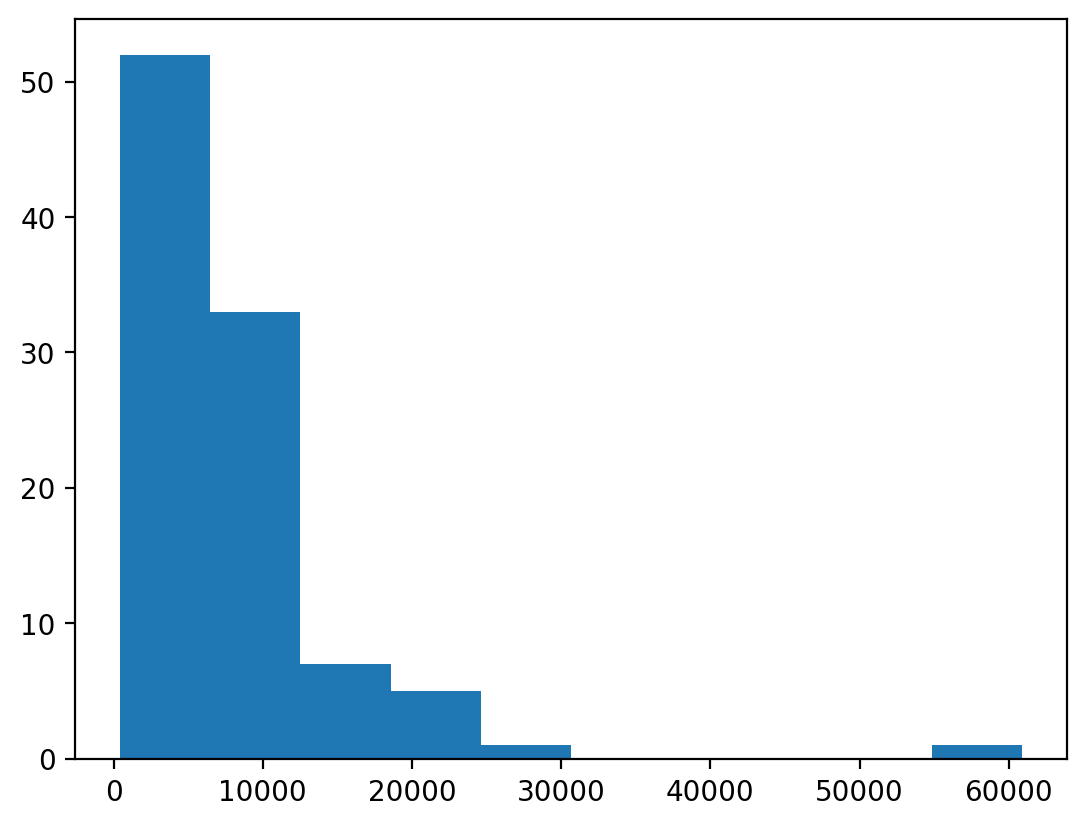

In [ ]:
song_length = []
for f in dataset_files:
  notes_list = get_midi_file_notes(f)
  song_length.append(len(notes_list))
print(song_length)
series = pd.Series(song_length)
series.describe()
plt.hist(series)
plt.show()

In [ ]:
series.describe()

count       99.000000
mean      8111.909091
std       7468.506412
min        430.000000
25%       4293.000000
50%       6161.000000
75%       9450.500000
max      60878.000000
dtype: float64

**REMOVING OUTLIERS**

In [ ]:
cut_off = 20000
song_length = []
remove_list = []
for f in dataset_files:
  notes_list = get_midi_file_notes(f)
  if len(notes_list) < cut_off and len(notes_list) > 250:
    song_length.append(len(notes_list))
  else:
    remove_list.append(f)

In [ ]:
for f in remove_list:
  dataset_files.remove(f)

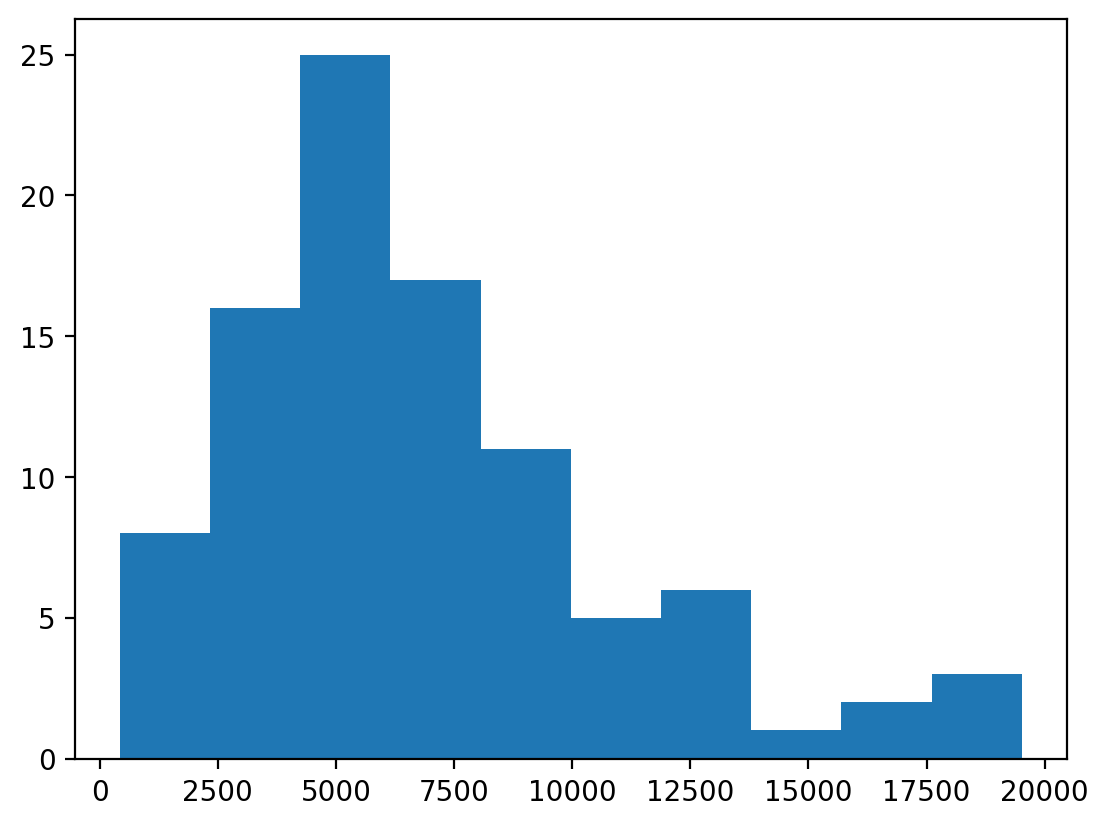

In [ ]:
series = pd.Series(song_length)
series.describe()
plt.hist(series)
plt.show()

In [ ]:
series.describe()

count       94.000000
mean      6899.531915
std       4076.168264
min        430.000000
25%       4111.500000
50%       6081.500000
75%       8993.750000
max      19514.000000
dtype: float64

94


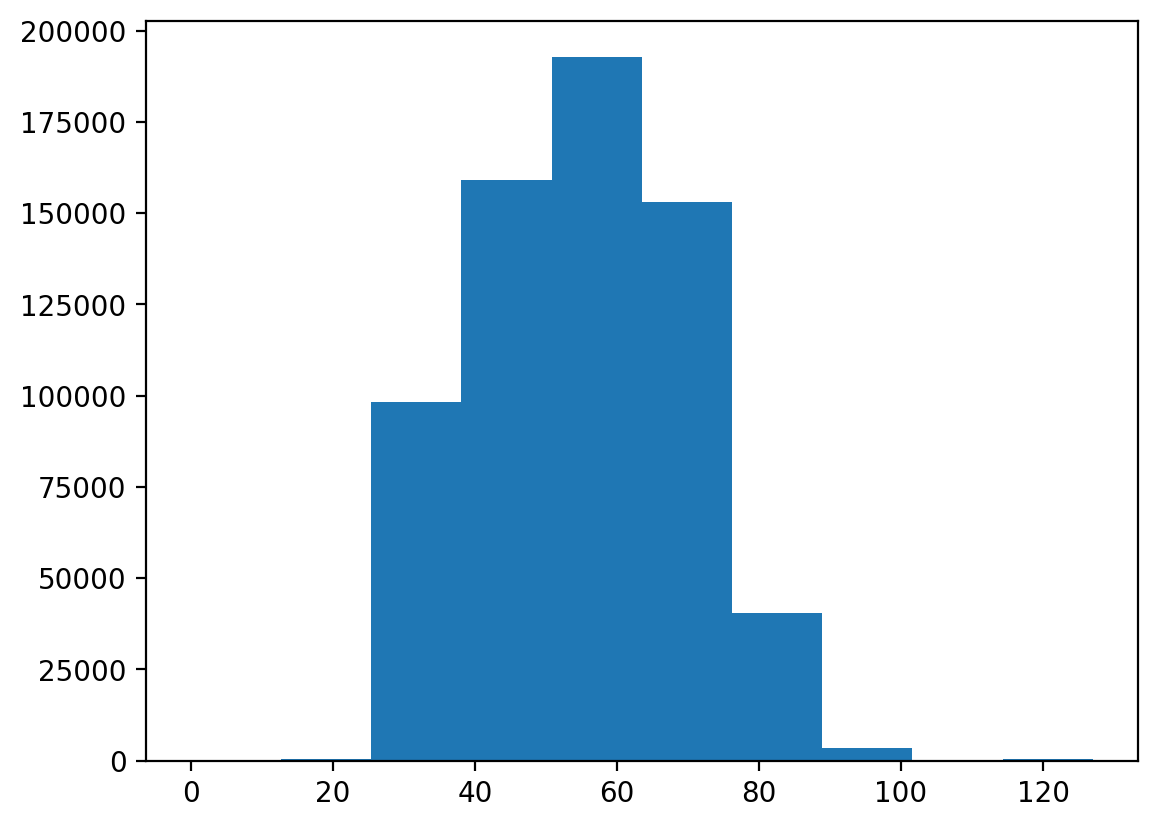

0    42
dtype: int64

In [ ]:
note_freq = []
i = 0
for f in dataset_files:
  notes_list = get_midi_file_notes(f)
  note_freq.extend(notes_list)
  i += 1
print(i)
note_frequency = pd.Series(note_freq)
plt.hist(note_frequency)
plt.show()
note_frequency.mode(dropna=True)

**DATA TRANSFORMATION**

In [ ]:
CONTEXT_LENGTH = 40
def gen_input_output(notes, context_length=CONTEXT_LENGTH):
    """
    Generate a list of training data points, each of the form (x, t),
    where "x" is a list of length `context_length` consisting of the
    previous notes, and "t" is the corresponding next note.

    Parameters:
        `notes` - a sequence of notes in a piece, generated
                  from calling `get_midi_file_notes`
        `context_length` - length of each context

    Returns: a list of training pairs (x, t), with len(x) == context_length
    """
    D = []
    for i in range(len(notes) - context_length):
        seq = notes[i:i+context_length]
        next_note = notes[i+context_length]
        D.append((seq, next_note),)
    
    D.append((notes[-context_length:], 0),)
    # Since the note 0 never appears in any of our pieces,
    # we use note 0 to denote END OF SONG. In general, we choose
    # a special value to denote the END OF SONG (usually a new
    # category that doesn't match an actual note), so that our
    # model might learn to end a song.
    return D

In [ ]:
def make_onehot(indicies, total=128):
    """
    Convert indicies into one-hot vectors by
    first creating an identity matrix of shape [total, total],
    then indexing the appropriate columns of that identity matrix.

    Parameters:
        `indices` - a numpy array of some shape where 
                    the value in these arrays should correspond to category
                    indices (e.g. note values between 0-127)
        `total` - the total number of categories (e.g. total number of notes)

    Returns: a numpy array of one-hot vectors
        If the `indices` array is shaped (N,)
           then the returned array will be shaped (N, total)
        If the `indices` array is shaped (N, D)
           then the returned array will be shaped (N, D, total)
        ... and so on.
    """
    I = np.eye(total)
    return I[indicies]

In [ ]:
def get_X_t(D):
    """
    Generate the data matrix "X" and target vector "t" from a data set "D",

    Parameters:
        `D` - a list of pairs of the form (x, t), returned from
              the function `gen_input_output`

    Returns: a tuple (X, t) where
        `X` - a numpy array of shape (N, D), the data matrix
        `t` - a numpy array of shape (N,),
              with each value representing the index of the target note
    """
    t = np.array([next_note for seq, next_note in D])
    X_ids = np.array([seq for seq, next_note in D])
    X = make_onehot(X_ids)
    X = X.reshape(X.shape[0], -1)
    return X,t 

In [ ]:
def generate_data_for_files(files):
    Xs, ts = [], []
    for file in files:
        try:
          notes = get_midi_file_notes(file)
          D = gen_input_output(notes)
          X, t = get_X_t(D)
          Xs.append(X)
          ts.append(t)
        except Exception as e:
          print(f"song:{file}   error:{e}")
    X = np.concatenate(Xs, axis=0)
    t = np.concatenate(ts, axis=0)
    df = np.concatenate((X, np.reshape(t, (-1, 1))), axis = 1)
    return X, t, df

In [ ]:
X_train, t_train, df_train = generate_data_for_files(dataset_files[:31])
X_val, t_val, df_val = generate_data_for_files(dataset_files[31:41])
X_test, t_test, df_test = generate_data_for_files(dataset_files[41:])

In [ ]:
t_train[0] == df_train[0][-1]

True

In [ ]:
df_train = pd.DataFrame(df_train)
df_val = pd.DataFrame(df_val)
df_test = pd.DataFrame(df_test)

In [ ]:
from google.colab import files
df_train.to_csv('training.csv', encoding = 'utf-8-sig') 
files.download('training.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_val.to_csv('validation.csv', encoding = 'utf-8-sig') 
files.download('validation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_test.to_csv('test.csv', encoding = 'utf-8-sig') 
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>